# Análisis y generación de gráficos enfocado en estacionalidad

Este notebook contiene un análisis enfocados en estacionalidad sobre los datos de encuestas recopilados para el proyecto MIT LIFT LAB. (Octubre 2025 - encuesta inicial).

Algunos de los gráficos ya fueron generados en el notebook anterior, el propósito ahora es aislarlo y generar adicionales relacionados a estacionalidad.

In [1]:
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 150

In [2]:
def find_project_root(start: Path) -> Path:
    current = start.resolve()
    if current.is_file():
        current = current.parent
    for parent in [current, *current.parents]:
        if (parent / 'pyproject.toml').exists():
            return parent
    # Fallback: dos niveles arriba (comportamiento previo)
    return current.parent.parent

PROJECT_ROOT = find_project_root(Path.cwd())
DATA_PATH = PROJECT_ROOT / 'src' / 'data' / 'processed' / 'clean_survey_to_analyze.csv'
VIZ_DIR = PROJECT_ROOT / 'src' / 'viz'
VIZ_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
df = pd.read_csv(DATA_PATH)
print('Filas/columnas:', df.shape)
df.head(3)

Filas/columnas: (923, 42)


,tipo_negocio,tiene_reja,anio_apertura,trabajadores_total,trabajadores_salario_fijo,expectativa_trabajadores_3m,ventas_vs_mes_anterior,razon_cambio_ventas,expectativa_ventas_3m,cambio_inventario,...,tipo_local,educacion,rango_edad,latitud,longitud,salario_dejar_negocio_num,salario_dejar_negocio_text,consumo_energia_kw_num,consumo_energia_kw_text,consumo_energia_kw_cash
0,Almacén,False,1980.0,1.0,0.0,Permanezca igual,Peor,Grandes empresarios aumentan los costos,Menores,Disminuyó,...,Propio,Primaria,Más de 60,34.770292,-58.222781,0.0,NaN,NaN,NaN,NaN
1,Pescadería,False,2024.0,1.0,0.0,Aumente,Igual,Proximos meses: estacionalidad de las fiestas,Mayores,Permaneció igual,...,Propio,Universidad y más,De 51 a 60,-34.577490,-58.430476,NaN,no estaria dispuesta a dejarlo,1012.0,NaN,NaN
2,Dietéticas,False,1980.0,2.0,0.0,Permanezca igual,Igual,NaN,Mayores,Permaneció igual,...,Rentado,Universidad y más,Más de 60,-34.577034,-58.430847,13000000.0,NaN,NaN,no sabe,NaN


## Figura 1 — Nube de palabras (razones de cambio en ventas)

Nota: esto es un análisis exploratorio de frecuencia de términos (no un puntaje de sentimiento).

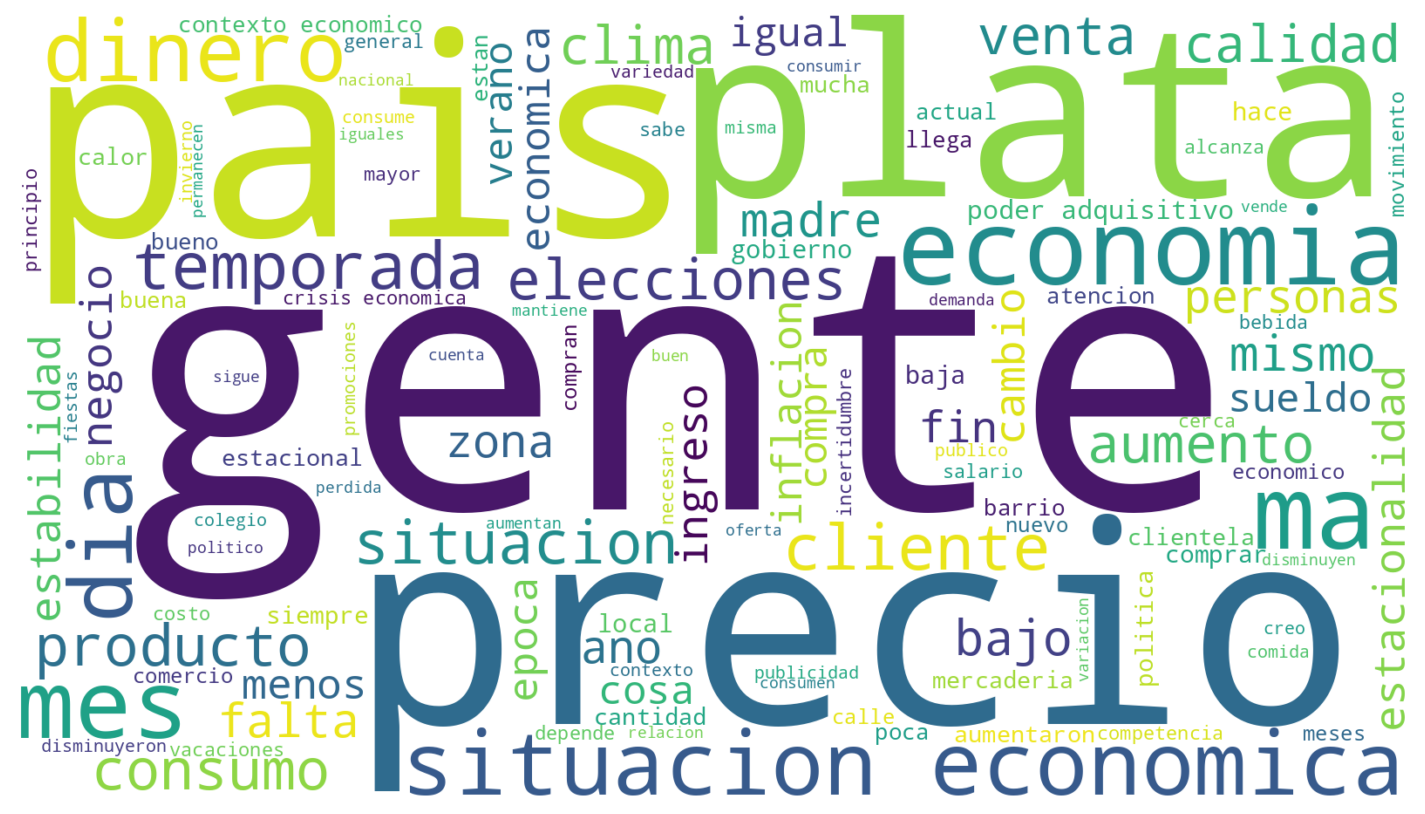

In [4]:
try:
    _ = stopwords.words('spanish')
except LookupError:
    nltk.download('stopwords')

STOPWORDS_ES = set(stopwords.words('spanish'))

def normalizar_texto(s: str) -> str:
    if pd.isna(s):
        return ''
    s = str(s).lower()
    s = unidecode(s)
    s = re.sub(r'[^\w\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# Columna interna (no usar en el texto del informe)
text_col = 'razon_cambio_ventas'
text_series = df[text_col].dropna().astype(str)
texto = ' '.join(normalizar_texto(x) for x in text_series)

if not texto.strip():
    raise ValueError('No hay texto suficiente para generar la nube de palabras.')

wc = WordCloud(
    width=1600,
    height=900,
    background_color='white',
    stopwords=STOPWORDS_ES,
    colormap='viridis',
    max_words=120,
    relative_scaling=0.5,
    min_font_size=10,
).generate(texto)

fig, ax = plt.subplots(figsize=(12, 7))
ax.imshow(wc, interpolation='bilinear')
ax.axis('off')

out1 = VIZ_DIR / 'figura_1_nube_palabras_ventas.png'
fig.savefig(out1, bbox_inches='tight')
plt.show()

## Figura 2 — Gráfico de barras (Expectativas de ventas a 3 meses)

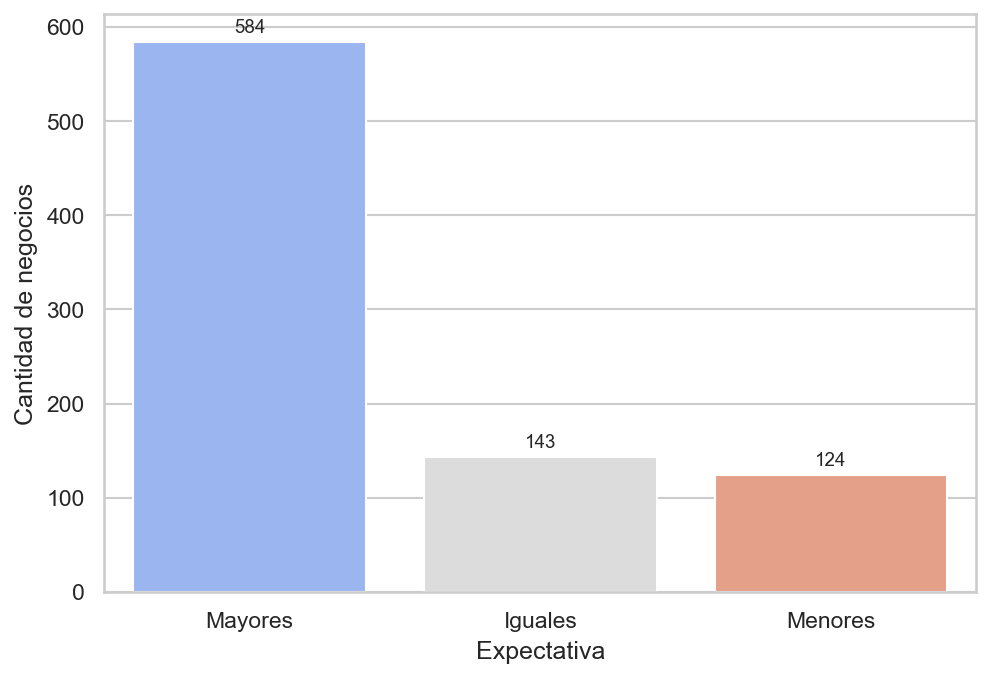

In [5]:
exp_col = 'expectativa_ventas_3m'

exp = df[exp_col].dropna().astype(str)
order = ['Mayores', 'Iguales', 'Menores']
counts = exp.value_counts()
counts = counts.reindex([x for x in order if x in counts.index]).fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(7.5, 5))
sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette='coolwarm', legend=False, ax=ax)
ax.set_xlabel('Expectativa')
ax.set_ylabel('Cantidad de negocios')

ymax = max(counts.values) if len(counts.values) else 0
for i, v in enumerate(counts.values):
    ax.text(i, v + ymax * 0.01, str(int(v)), ha='center', va='bottom', fontsize=9)

out2 = VIZ_DIR / 'figura_2_expectativa_ventas_3m.png'
fig.savefig(out2, bbox_inches='tight')
plt.show()

## Figura 3 — Consistencia entre expectativas y desempeño reciente (mapa de calor)

Se construye un indicador simple de consistencia: si la categoría de expectativa (mejor/igual/peor) coincide con la percepción reportada de ventas respecto al mes anterior. Luego se calcula el porcentaje de coincidencia por tipo de negocio y antigüedad (en grupos).

Este indicador no mide ventas reales; resume consistencia interna entre respuestas del encuestado.

**Lectura rápida:** un % alto sugiere expectativas que extrapolan el último mes; un % bajo sugiere expectativas que no siguen el último mes (posible estacionalidad o shock).

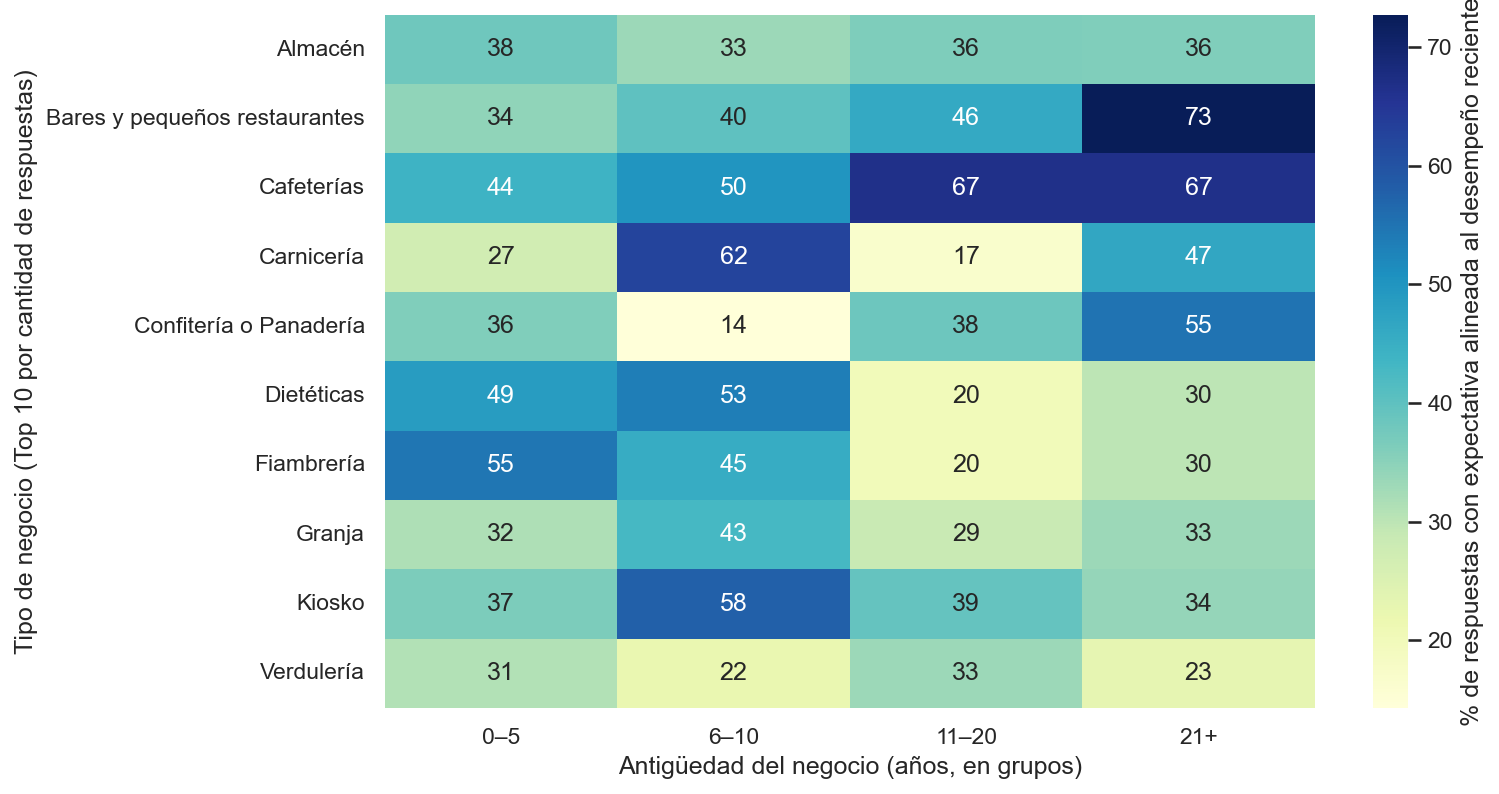

In [6]:
exp_col = 'expectativa_ventas_3m'       # interna
sales_col = 'ventas_vs_mes_anterior'   # interna
type_col = 'tipo_negocio'              # interna
year_open_col = 'anio_apertura'        # interna

tmp = df[[exp_col, sales_col, type_col, year_open_col]].copy()
tmp = tmp.dropna(subset=[exp_col, sales_col, type_col, year_open_col])

def norm_cat(s: str) -> str:
    s = str(s).strip().lower()
    s = unidecode(s)
    if 'mayor' in s or 'mejor' in s or 'aument' in s:
        return 'mejor'
    if 'igual' in s or 'mantuvo' in s:
        return 'igual'
    if 'menor' in s or 'peor' in s or 'baj' in s or 'dismin' in s:
        return 'peor'
    return 'otro'

tmp['exp_norm'] = tmp[exp_col].apply(norm_cat)
tmp['sales_norm'] = tmp[sales_col].apply(norm_cat)
tmp = tmp[(tmp['exp_norm'] != 'otro') & (tmp['sales_norm'] != 'otro')].copy()

# Antigüedad del negocio (año de referencia 2025; ajustar si se usa otra ventana)
tmp['antiguedad'] = 2025 - pd.to_numeric(tmp[year_open_col], errors='coerce')
tmp = tmp.dropna(subset=['antiguedad'])

bins = [0, 5, 10, 20, 100]
labels = ['0–5', '6–10', '11–20', '21+']
tmp['antiguedad_grupo'] = pd.cut(tmp['antiguedad'], bins=bins, labels=labels, include_lowest=True)

tmp['coincide'] = (tmp['exp_norm'] == tmp['sales_norm']).astype(int)

# Para legibilidad: top 10 tipos con más observaciones
top_types = tmp[type_col].value_counts().head(10).index
tmp2 = tmp[tmp[type_col].isin(top_types)].copy()

heat = (
    tmp2.groupby([type_col, 'antiguedad_grupo'], observed=False)['coincide']
    .mean()
    .mul(100)
    .unstack('antiguedad_grupo')
    .reindex(index=top_types)
    .sort_index()
 )

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    heat,
    annot=True,
    fmt='.0f',
    cmap='YlGnBu',
    cbar_kws={'label': '% de respuestas con expectativa alineada al desempeño reciente'},
    ax=ax,
 )
ax.set_xlabel('Antigüedad del negocio (años, en grupos)')
ax.set_ylabel('Tipo de negocio (Top 10 por cantidad de respuestas)')

out3 = VIZ_DIR / 'figura_3_consistencia_expectativa_vs_ventas.png'
fig.savefig(out3, bbox_inches='tight')
plt.show()